In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import random
import re
from collections import defaultdict
import glob
from pyitlib import discrete_random_variable as drv
import _pickle as cPickle
import zlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import xgboost as xgb
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.svm import SVR

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
RANDOM_STATE = 50

# Problem 1

**Read Shannon’s 1948 paper ’A Mathematical Theory of Communication’.  Focus on pages 1-19 (upto Part II), the remaining part is more relevant for communication.**

The central goal of this paper is to find a general theory of communication. The fundamental problem of communication lies in the reproduction of messages between a source and destination for a communication system. Sometimes the correct message to be reproduced must be selected from a group of possible messages. If each message in the group has an equally likely choice of being the correct original message, you can use a logarithmic function to estimate the amount of information being sent.

A communication system has five parts: an information source that produces a message, a transmitter that transforms the message somehow to make it transferable, a channel that transports the message from a transmitter to the receiver, a receiver that performs the inverse transformation of the transmitter, and finally a destination that gets the message from the receiver. There are three types of information systems: discrete, continuous, and mixed. Noise is also introduced to the channel. A key aspect to a communications system is how that noise can be filtered out to properly extract the original message. 

One central question is how can we measure the capacity of a channel to transmit information. There is a formula for it, C = Lim(T->infinity) [ logN(T) / T ], and you can also always condense discrete sequences by only tracking changes in state. A communication system that uses discrete symbols with probabilities of being chosen is known as a stochastic process. We can approximate the english language by increasing the order of approximation in the stochastic process. A stochastic process is also known as a discrete Markhoff process. We can represent these Markhoff processes as state diagrams with probabilities connected to state changes. There’s a group of markhoff processes called ergodic processes, which are basically graphs where every node is connected to every other node, with a path back (not periodic). If graphs are disjoint, they can be split into multiple ergodic processes. 

H(p1,...,pn) defines the ‘uncertainty’ of an event, and this uncertainty should increase linearly with ‘n’ if pi = 1/n for all i < n. We know that H = -Ksum(pi(log(pi)) where K is a positive constant. We can also find the entropy of each finite state from a discrete finite state source. The mathematical operations used to code and decode information comprise a discrete transducer. Additionally the output of the a finite state transducer is a finite state statistical source with an entropy H less than or equal to the entropy of the input. If a source has entropy H and a channel capacity C, we can encode the source output at an average rate greater than C/H.


# Problem 2

**ICML is a top research conference in Machine learning.  Scrape all the pdfs of all ICML 2017 papersfrom http://proceedings.mlr.press/v70/**

In [ ]:
# Gets a dataframe of all alphanumeric words, repeats possible
word_dict = {'word' : [], 'source' : []}

txt_doc_names = glob.glob("*.pdf.txt")
txt_doc_names.sort()

for txt_doc_name in txt_doc_names:
    with open(txt_doc_name, 'r', encoding="utf-8") as file:
        words = file.read().replace('\n', ' ').replace('_', '')
    pattern = re.compile('[^\w\s]')
    words = pattern.sub(' ', words)
    pattern = re.compile('CID:\S+')
    words = pattern.sub('', words)
    word_list = words.split()

    for word in word_list:
        word = word.lower()
        if (word != ' ') and (len(word) > 0) and (word[0] != ' ') and (word != len(word) * word[0]):
            pattern = re.compile('[\s]')
            word = pattern.sub('', word)
            word_dict['word'].append(word)
            word_dict['source'].append(txt_doc_name)
        
word_df = pd.DataFrame(word_dict, columns = ['word', 'source'])

In [ ]:
# Creates a dataframe where each word and punctuation symbol is a row, with repeated words possible
word_punc_dict = {'word' : [], 'source' : []}

txt_doc_names = glob.glob("*.pdf.txt")
txt_doc_names.sort()

for txt_doc_name in txt_doc_names:   
    with open(txt_doc_name, 'r', encoding="utf-8") as file:
        words = file.read().replace('-\n', '').replace('\n', ' ')
        
    pattern = re.compile('\(CID\S+')
    words = pattern.sub(' ', words)
    pattern = re.compile('\(cid\S+')
    words = pattern.sub(' ', words)
    pattern = re.compile('\<\S+')
    words = pattern.sub(' ', words)
  
    word_list = re.split('(\W+)', words)

    for word in word_list:
        word = word.lower()
        if (len(word) > 0) and (word[0] != ' ') and (word != len(word) * word[0]):
            pattern = re.compile('[\s]')
            word = pattern.sub('', word)
            if (len(word) > 1) and not word.isalnum():
                chars = list(word)
                for char in chars:
                    word_punc_dict['word'].append(char)
                    word_punc_dict['source'].append(txt_doc_name)
            else:
                word_punc_dict['word'].append(word)
                word_punc_dict['source'].append(txt_doc_name)
        
word_punc_df = pd.DataFrame(word_punc_dict, columns = ['word', 'source'])

## 1. What are the top 10 common words in the ICML papers?

In [ ]:
word_df['word'].value_counts().head(10)

## 2. Let Z be a randomly selected word in a randomly selected ICML paper.  Estimate the entropy of Z.

To calculate entropy meant calculating all joint and conditional probabilities for words and sources in all texts. This is possible, but not on my machine, since there are so many words in the original dataframe. There are two ways I found to do this: first by getting the value from base probabilities, second by using an external library. The last command is runnable, and has the fastest runtime, but I do not have enough memory to run it.

In [ ]:
# Method 1 calculating probability by probability (logic is there, I just couldn't run it)

def prob_dict(a):
    # Make dictionary of probabilities
    a_list = a.tolist()
    
    a_counts = {}
    total = len(a_list)
    
    for key in a_list:
        if key in a_counts:
            a_counts[key] = a_counts[key] + 1
        else:
            a_counts[key] = 1
    
    a_probs = a_counts
    
    for key in a_probs.keys():
        a_probs[key] = a_probs[key]/total
        
    return(a_probs)

def count_arr(df):
    df_arr = np.array(df)
    
    a = df['word']
    b = df['source']
    b_unq = b.unique()
    a_unq = a.unique()
    
    b_map = {}
    ind = 0
    for item in b_unq:
        b_map[item] = ind
        ind += 1
        
    a_map = {}
    ind = 0
    for item in a_unq:
        a_map[item] = ind
        ind += 1
        
    count_arr = np.zeros((len(a_map.keys()), len(b_map.keys()))) 
    count_len = len(df_arr)
    for i in range(count_len):
        a_val = df_arr[i][0]
        b_val = df_arr[i][1]
        a_ind = a_map[a_val]
        b_ind = b_map[b_val]
        count_arr[a_ind][b_ind] += 1 
        
    return(count_arr)

def joint_prob_arr(df):
    counts = count_arr(df)
    joint_probs = counts
            
    for i in range(len(counts)):
        for j in range(len(counts[0])):
            joint_probs[i][j] = (1/len(counts[0]))*(counts[i][j]/np.sum(counts[:,j]))
            
    return(joint_probs)
            
def cond_prob_arr(df, joint_probs):
    a = df['word']
    a_probs = prob_dict(a)
    a_unq = a.unique()
    a_map = {}
    ind = 0
    for item in a_unq:
        a_map[ind] = item
        ind += 1
        
    cond_probs = joint_probs
    
    for i in range(len(joint_probs)):
        for j in range(len(joint_probs[0])):
            cond_probs[i][j] = joint_probs[i][j]/a_probs[a_map[i]]
            
    return(cond_probs)
    
def cond_entropy(df):
    joint_probs = joint_prob_arr(df)
    cond_probs = cond_prob_arr(df, joint_probs)
    
    sum = 0
    for i in range(len(joint_probs)):
        for j in range(len(joint_probs)[0]):
            sum += joint_probs[i][j]*np.log2(cond_probs[i][j])
    
    return(sum)
    # Make 2-D array of conditional probabilities
    
    # Calculate conditional entropy
    

In [ ]:
# Alternative of method 1, more condensed but less efficient
def get_joint_prob(word, source, df):
    word_freq = df[df['source'] == source][df['word'] == word].shape[0]
    words_in_source = df[df['source'] == source].shape[0]
    num_sources = df['source'].unique().shape[0]
    prob = (1 / num_sources) * (word_freq / words_in_source)
    return(prob)

def get_prob(word, df):
    word_freq = df[df['word'] == word].shape[0]
    total_words = df.shape[0]
    prob = word_freq / total_words
    return(prob)

def get_cond_prob(word, source, df):
    prob = get_prob(word, df)
    joint = get_joint_prob(word, source, df)
    cond = joint / prob
    return(cond)

def get_cond_entropy(df):
    unique_sources = df['source'].unique().tolist()
    sum = 0
    for source in unique_sources:
        unique_words = df[df['source'] == source]['word'].unique().tolist()
        for word in unique_words:
            sum += get_joint_prob(word, source, df) * np.log2(get_cond_prob(word, source, df))
    return(-sum)    

In [ ]:
# Method 2, external library
drv.entropy_conditional(word_df['word'].tolist(), word_df['source'].tolist())

## 3. Synthesize a random paragraph using the marginal distribution over words.

In [ ]:
NUM_PARA_WORDS = 100
para = ''
num_words = word_df.shape[0]

for i in range(NUM_PARA_WORDS):
    word_ind = np.random.randint(num_words)
    word = word_df.iat[word_ind, 0] + ' '
    para = para + word
    
print(para)

## 4. (Extra credit) Synthesize a random paragraph using an n-gram model on words.  Synthesize a random paragraph using any model you want.  Top five synthesized text paragraphs win bonus (+30 points)

In [ ]:
# Adding a column to keep track of a default value
TOTAL_WORDS += 1
all_unique_words = word_punc_df['word'].unique()

In [ ]:
n = 15

def compress(t):
    return zlib.compress(cPickle.dumps(t))

def decompress(t):
    return cPickle.loads(zlib.decompress(t))

sparseMatrixLike = defaultdict(np.float16)
sparseMatrixLike[compress(tuple([None] * n))] = 0.0

words_in_order = word_punc_df['word'].to_list()

prevData = []
prevData.append(None)
for i in range(n):
    prevData.append(words_in_order[i])


for word in words_in_order[n-1:]:
    prevData.append(word)
    prevData.pop(0)
    args = tuple(list([prevData[x] for x in range(0,n)]))
    for i in range(n):
        sparseMatrixLike[compress(args)] +=1
        l = list(args)[1:]
        l.append(None)
        args = tuple(l)

In [ ]:
divisor = len(words_in_order) - (n-1)
for k, v in sparseMatrixLike.items():
    sparseMatrixLike[k] = sparseMatrixLike[k] / (divisor)

In [ ]:
sparseLike = sparseMatrixLike
def stupid_fall_back_fill(words, word_list):
    global sparseLike
    global n
    for word in word_list:
        sparseLike[compress(tuple(words + [word]))] = stupid_fall_back(tuple(words + [word]), n-1)

def stupid_fall_back(words, index):
    global sparseLike
    if compress(words) in sparseLike:
        return sparseLike[compress(words)]
    l = list(words)[1:]
    l.append(None)
    words = tuple(l)
    return 0.2 * stupid_fall_back(words, index - 1)

message = ['to', 'illustrate', 'the', 'properties', 'of', 'our', 'model', ',', 'we', 'compared', 'its', 'accuracy', 'to', 'the']

import random
for i in range(200):
    print(message[0], end=' ')
    word_list = [x for x in all_unique_words if (compress((message[n-3],message[n-2],x,None,None,None,None,None,None,None,None,None,None,None,None)) in sparseLike)]
    
    if len(word_list) < 2:
        word_list = [x for x in all_unique_words if (compress((message[n-2],x,None,None,None,None,None,None,None,None,None,None,None,None,None)) in sparseLike)]
        if len(word_list) < 2:
            word_list = [x for x in all_unique_words if (compress((x,None,None,None,None,None,None,None,None,None,None,None,None,None,None)) in sparseLike)]
        
    stupid_fall_back_fill(message, word_list)
    
    maxVal = 0.0
    for sel in word_list:
        maxVal += sparseLike[compress(tuple(message + [sel]))]
    x = random.uniform(0, 1) * maxVal
    
    looped = True
    for sel in word_list:
        x -= sparseLike[compress(tuple(message + [sel]))]
        if x < 0:
            message.append(sel)
            message.pop(0)
            looped = False
            break
    if looped == True:
        print(message)
        print(maxVal)
        print(word_list)
        break
            
while len(message) > 0:
    print(message[0], end=' ')
    message.pop(0)
        

# Problem 3

## Data Pre-Processing

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47ecb01080>,
      dtype=object)

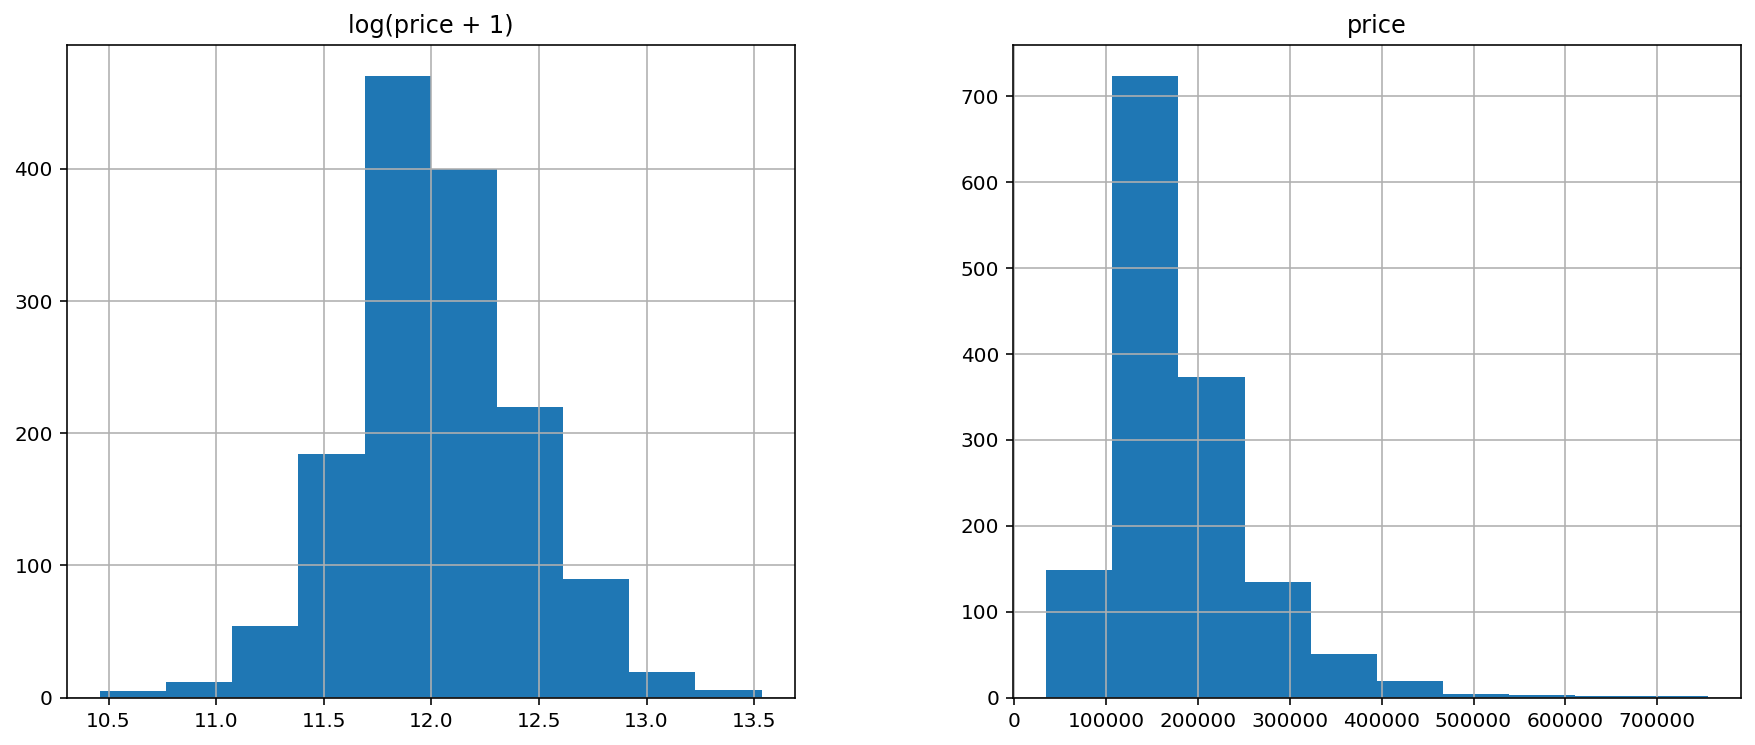

In [ ]:
matplotlib.rcParams['figure.figsize'] = (15.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [ ]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [ ]:
all_data = pd.get_dummies(all_data)

In [ ]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [ ]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

## Ridge Regression

In [ ]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
model_ridge = Ridge()

In [ ]:
alphas = [0.1]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
print("rmse for alpha = 0.1:", cv_ridge)

In [ ]:
# optimize alpha value
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

optimalAlpha = cv_ridge[cv_ridge == cv_ridge.min()].index[0]
print("Optimal alpha:",optimalAlpha)
print("rmse: ", cv_ridge.min())
rmse1 = cv_ridge.min()

In [ ]:
# train model
ridge = Ridge(alpha=optimalAlpha)
ridge.fit(X_train, y)
yPredict = ridge.predict(X_test)
yPredict = np.expm1(yPredict)

In [ ]:
# add output as feature
X_train_stack = X_train
Predicted_Y = pd.DataFrame({"Predicted Y":yPredict})
Predicted_Y = Predicted_Y.append(Predicted_Y.loc[0], yPredict.mean())
X_train_stack = X_train_stack.assign(Predicted_Y = Predicted_Y.values)
X_train_stack

In [ ]:
# optimize alpha value for stacked model

def rmse_cv_stacked(model):
    rmse= np.sqrt(-cross_val_score(model, X_train_stack, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv_stacked(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
optimalAlpha = cv_ridge[cv_ridge == cv_ridge.min()].index[0]

print("Optimal alpha:",optimalAlpha)
print("rmse2: ", cv_ridge.min())
rmse2 = cv_ridge.min()

# train stacked model
ridge2 = Ridge(alpha=optimalAlpha)
ridge2.fit(X_train_stack, y)
yPredict2 = ridge.predict(X_test)
yPredict2 = np.expm1(yPredict2)

# stacked ridge model vs original model?
print("Is rmse2 larger than rmse1?", rmse2 > rmse1)

## LASSO Regression

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()

0.12256735885048142

In [ ]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso kept " + str(sum(coef != 0)) + " fields and eliminated " + str(sum(coef==0)) + " fields")

Lasso kept 110 fields and eliminated 178 fields


Text(0.5, 1.0, 'Lasso Coefficients')

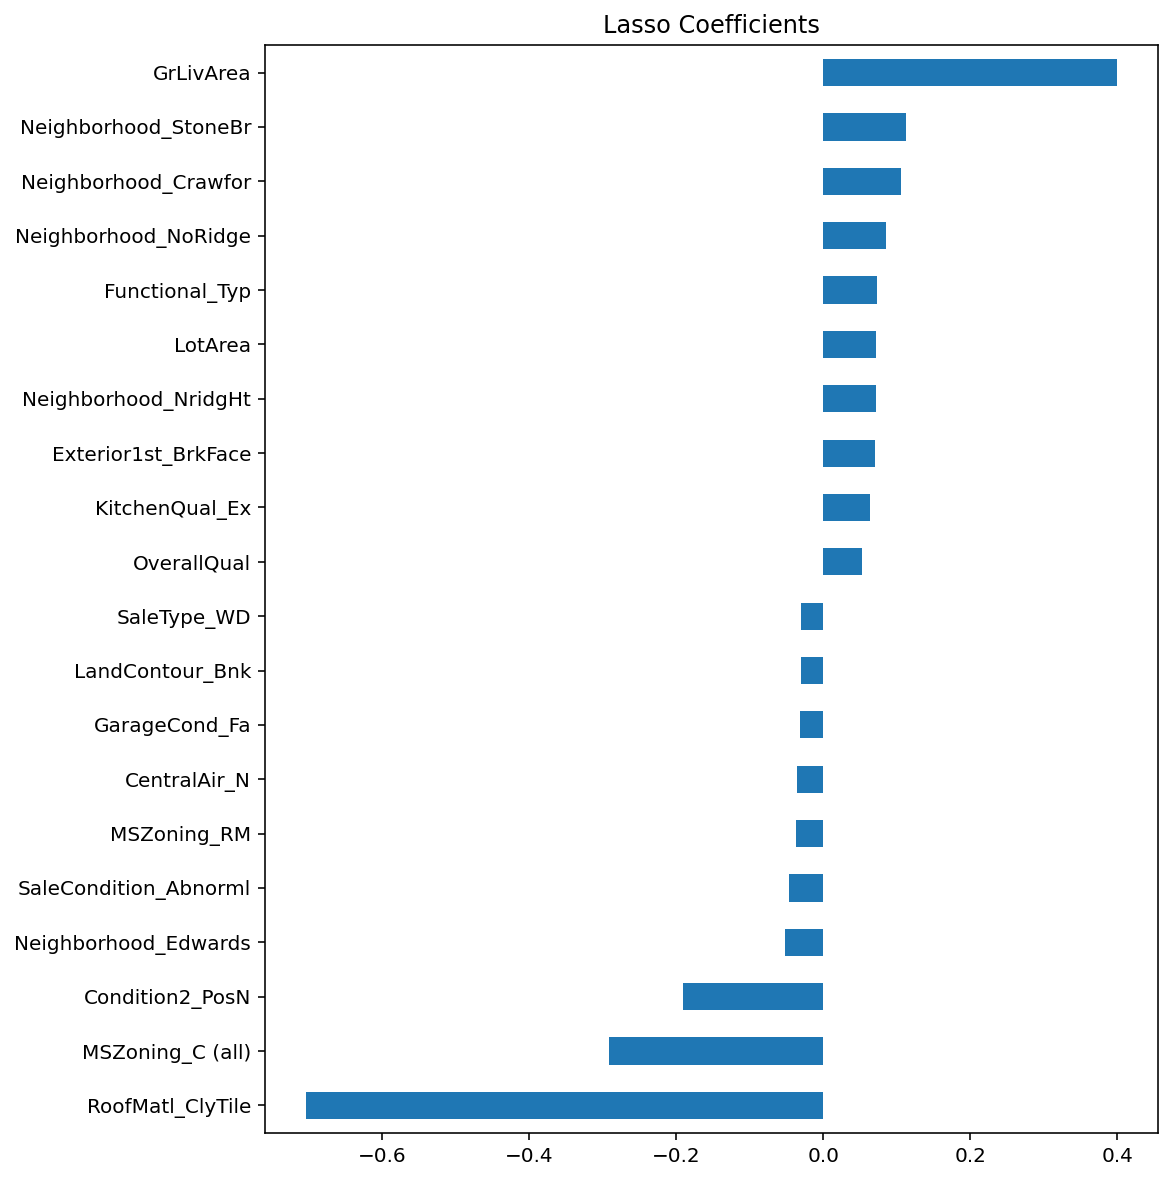

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Lasso Coefficients")

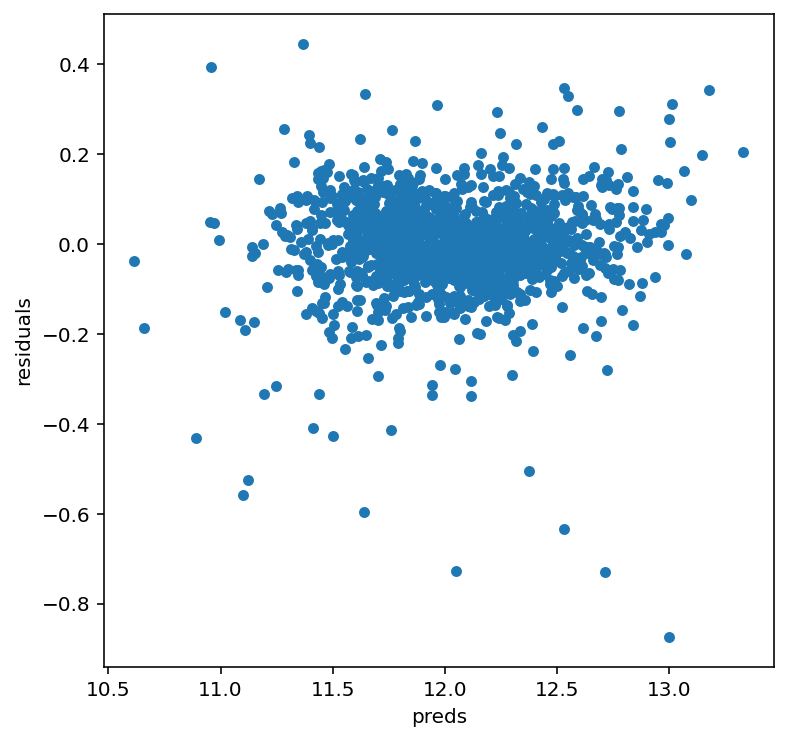

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

## XGBoost Regression

Finding the best hyperpararameters for XGBoost Regression using GridSearchCV. Originally these dictionaries had a lot more values, but they were condensed through trial and error.

In [ ]:
xgb_model = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.15],
    'max_depth': [3],
    'min_child_weight': [1],
    'gamma': [0.1],
    'colsample_bytree': [0.4],
    'n_estimators': [325]}

MSE = make_scorer(mean_squared_error, greater_is_better=False)
model = GridSearchCV(estimator=xgb_model, param_grid=param_grid, n_jobs=-1, cv=3, scoring=MSE, verbose=2)
model.fit(X_train, y)
print('XGBoost Regression...')
print('Best Params:', model.best_params_)
print('Best CV Score:', -model.best_score_)

In [ ]:
params = {'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 325}
model_xgb = xgb.XGBRegressor(**params)

## Random Forest Regression

Finding the best hyperpararameters for Random Forest Regression using GridSearchCV. Originally these dictionaries had a lot more values, but they were condensed through trial and error.

In [ ]:
rfr = RandomForestRegressor(verbose=0)

param_grid = {
    'bootstrap': [True],
    'max_depth': [96],
    'max_features': ['auto'],
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'n_estimators': [2070]}

MSE = make_scorer(mean_squared_error, greater_is_better=False)
model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=-1, cv=3, scoring=MSE, verbose=2)
model.fit(X_train, y)
print('Random forest regression...')
print('Best Params:', model.best_params_)
print('Best CV Score:', -model.best_score_)

In [ ]:
params = {'bootstrap': True, 'max_depth': 96, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2070}
model_rfr = RandomForestRegressor(**params)

## SVR

We used GridSearchCV to tune the hyperparameters for the SVR model. Originally, the list of possible parameter values was quite extensive, but eventually got reduced to what is shown below based on trial and error.

In [ ]:
optimalSVR = GridSearchCV(estimator=SVR(kernel='rbf'), 
                   param_grid = {
                       'C': [0.1, 1, 10, 100, 10000, 15000],
                       'epsilon': [0.01, 0.012, 0.013, 0.0135],
                       'gamma': [8e-05,9e-05,9.5e-05,0.0001]
                   },
                   cv = 8,
                   scoring = 'neg_mean_squared_error',
                   verbose = 0,
                   n_jobs = -1)

optimalSVR.fit(X_train, y)

In [ ]:
print("Optimal Parameters:", optimalSVR.best_params_)
print("MSE: ", -optimalSVR.best_score_)
print("RMSE: ", np.sqrt(-optimalSVR.best_score_))
print("Standard Dev:", optimalSVR.cv_results_['std_test_score'][optimalSVR.best_index_])     

In [ ]:
svr_optimal = {'C': 100, 'epsilon': 0.0135, 'gamma': 8e-05}
model_svr = SVR(kernel='rbf', **svr_optimal)
model_svr.fit(X_train, y)

## GBM Regression


In [ ]:
model_lgbm = LGBMRegressor(boosting_type='gbdt', objective='regression', metric = 'rmse')

model_lgbm.fit(X_train, y)

rmse_cv(model_lgbm).mean()

MSE = make_scorer(mean_squared_error, greater_is_better=False)

param_grid_lgbm = {
    'num_leaves' : np.arange(-1,15,1),
    'max_depth' : np.arange(-1, 6, 1),
    'learning_rate' : np.arange(0.03,0.08,0.01),
    'n_estimators' : np.arange(400,450,10)
}

model_lgbm_hyper = GridSearchCV(estimator=model_lgbm, param_grid=param_grid_lgbm, n_jobs=-1, cv=4, scoring=MSE)

model_lgbm_hyper.fit(X_train,y)

score = -model_lgbm_hyper.best_score_

print('Best Params:\n', model_lgbm_hyper.best_params_)
print('Best CV Score:', score)

In [ ]:
saved_best = {'learning_rate': 0.060000000000000005, 'max_depth': -1, 'n_estimators': 420, 'num_leaves': 9}
model_lgbm_set = LGBMRegressor(boosting_type='gbdt', objective='regression', metric = 'rmse', **saved_best)
model_lgbm_set.fit(X_train,y)

rmse_cv(model_lgbm_set).mean()

0.12782947906259498

# Stacking Models

Finally, we compile our models using a stacking regressor and check which final estimator gives the least error using rmse. This was done through trial and error seeing which rmse value was the lowest for each final regressor.

RFR Meta Model rmse: 0.12510261384031024

XGB Meta Model rmse: 0.12492697684309169

Ridge Meta Model rmse: 0.11891085433887438

LGBM Meta Model rmse: 0.12746463317549858

Lasso Meta Model rmse: 0.11906390504408422

SVR Meta Model rmse: 0.11950418291006988

In [ ]:
estimators_stack = [('svr', model_svr),
                   ('rfr', model_rfr),
                    ('xgb', model_xgb),
                    ('lasso', model_lasso),
                    ('ridge', ridge),
                    ('gbm', model_lgbm_set)]
big_stacker = StackingRegressor(n_jobs = -1, estimators=estimators_stack, final_estimator=model_lasso)
big_stacker.fit(X_train, y)
rmse_cv(big_stacker).mean()

In [ ]:
output = np.expm1(big_stacker.predict(X_test))
out_db = pd.DataFrame()
out_db['Id'] = test['Id']
out_db['SalePrice'] = output
out_db.tail()

In [ ]:
out_db.to_csv('bigstacker.csv',index=False)

We found that the final scoring for the following meta-models was the lowest


*   SVR with 0.12085 RMSE
*   Ridge with 0.11968 RMSE
*   LASSO with 0.11913 RMSE

Because of these RMSE values, we produced our results using a LASSO meta-model

